In [1]:
!pip install pandas numpy scikit-learn matplotlib azure-identity azure-keyvault-secrets azure-cosmos seaborn joblib


In [2]:
!pip install --upgrade azure-cosmos


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 303.2/303.2 kB 8.3 MB/s eta 0:00:0000:01
  Attempting uninstall: azure-cosmos
    Found existing installation: azure-cosmos 3.2.0
    Uninstalling azure-cosmos-3.2.0:
      Successfully uninstalled azure-cosmos-3.2.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
azure-cli 2.75.0 requires azure-cosmos>=3.0.2,~=3.0, but you have azure-cosmos 4.9.0 which is incompatible.
azure-cli 2.75.0 requires azure-datalake-store~=1.0.1, but you have azure-datalake-store 0.0.53 which is incompatible.
azure-cli 2.75.0 requires azure-keyvault-keys==4.11.0b1, but you have azure-keyvault-keys 4.8.0 which is incompatible.
azure-cli 2.75.0 requires azure-mgmt-containerregistry==14.1.0b1, but you have azure-mgmt-containerregistry 9.0.0 which is incompatible.
azure-cli 2.75.0 requires azure-mgmt-keyvault==11.0.0, but you have azure-mgmt-k

In [4]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from azure.keyvault.secrets import SecretClient
from azure.identity import DefaultAzureCredential
from azure.cosmos import CosmosClient, PartitionKey, exceptions
import seaborn as sns
import joblib


Load data from cosmosDB for prediction

In [5]:
vault_url = "https://keycosmos.vault.azure.net/"
credential = DefaultAzureCredential()

# Create Key Vault client
kv_client = SecretClient(vault_url=vault_url, credential=credential)

try:
    # Retrieve Cosmos DB credentials from Key Vault
    url = kv_client.get_secret("COSMOS-LINK").value  
    key = kv_client.get_secret("COSMOS-KEY").value   
    print("Successfully retrieved credentials from Key Vault")
    
    # Cosmos DB configuration
    database_name = 'iot_data'
    container_name = 'vehicle_data'
    
    # Create Cosmos DB client
    client = CosmosClient(url, credential=key)
    database = client.get_database_client(database_name)
    container = database.get_container_client(container_name)
    
    # Fetch data
    print("Fetching data from Cosmos DB...")
    items = list(container.read_all_items())
    
    # Convert to DataFrame
    data = pd.DataFrame(items)
    
    print(f"Successfully loaded {len(data)} records from Cosmos DB")
    print(f"DataFrame shape: {data.shape}")
    print(" First few rows:")
    print(data.head())
    
    # Display column info
    print(f"\nColumns: {list(data.columns)}")
    
except Exception as e:
    print(f" Error: {e}")

Successfully retrieved credentials from Key Vault
Fetching data from Cosmos DB...
Successfully loaded 13904 records from Cosmos DB
DataFrame shape: (13904, 10)
 First few rows:
   connectionTime_decimal  chargingDuration  kWhDelivered dayIndicator  \
0               15.332910          2.301191     11.469551            1   
1               16.811495          4.941774      3.611695            1   
2               16.680561          0.875763      6.760685            1   
3               18.731514          1.246924      4.272613            1   
4               17.356366          5.696375     11.462980            1   

                                     id                      _rid  \
0  ed9f2e3e-991d-4ed1-b777-68587ce07c80  h49DAK0kYAVuAQAAAAAAAA==   
1  f4802970-ada8-418e-aa15-df6660b43b1d  h49DAK0kYAVvAQAAAAAAAA==   
2  0c7135bd-8d7a-468e-8dd4-18b6ce36e5bc  h49DAK0kYAVwAQAAAAAAAA==   
3  ff61cd1b-0579-4788-9d17-417c0b545831  h49DAK0kYAVxAQAAAAAAAA==   
4  81961847-97e3-4640-a520-0e23c8

In [6]:
print("\n Basic Info:")
print(data.info())

print("\n Descriptive Statistics:")
print(data.describe().T)

print("\n Missing Values:")
print(data.isnull().sum())



 Basic Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13904 entries, 0 to 13903
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   connectionTime_decimal  13904 non-null  float64
 1   chargingDuration        13904 non-null  float64
 2   kWhDelivered            13904 non-null  float64
 3   dayIndicator            13904 non-null  object 
 4   id                      13904 non-null  object 
 5   _rid                    13904 non-null  object 
 6   _self                   13904 non-null  object 
 7   _etag                   13904 non-null  object 
 8   _attachments            13904 non-null  object 
 9   _ts                     13904 non-null  int64  
dtypes: float64(3), int64(1), object(6)
memory usage: 1.1+ MB
None

 Descriptive Statistics:
                          count          mean           std           min  \
connectionTime_decimal  13904.0  1.469361e+01      6.286209  6.879605e-

Preprocessing

In [7]:
data.drop(columns=["id", "_rid", "_self", "_etag", "_attachments", "_ts"], inplace=True)
data.dropna(inplace=True)

Feature Engineering

In [8]:
data["avg_power"] = data["kWhDelivered"] / data["chargingDuration"].replace(0, np.nan)
data["connection_end_time"] = data["connectionTime_decimal"] + data["chargingDuration"]

Correlation Matrix 

In [9]:

pd.set_option('display.max_columns', None)       
pd.set_option('display.width', 1000)            
corr_matrix = data.corr(numeric_only=True)
print("Correlation Matrix:")
print(corr_matrix.round(2))


Correlation Matrix:
                        connectionTime_decimal  chargingDuration  kWhDelivered  avg_power  connection_end_time
connectionTime_decimal                    1.00              0.24          0.29      -0.08                 0.91
chargingDuration                          0.24              1.00          0.49      -0.15                 0.62
kWhDelivered                              0.29              0.49          1.00      -0.01                 0.44
avg_power                                -0.08             -0.15         -0.01       1.00                -0.13
connection_end_time                       0.91              0.62          0.44      -0.13                 1.00


Prepare features and target

In [11]:
X = data[["connectionTime_decimal", "chargingDuration", "avg_power", "connection_end_time"]]
y = data["kWhDelivered"]

Train-test split the data 

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Define models to compare

In [13]:
models = {
    "RandomForest": RandomForestRegressor(n_estimators=200, max_depth=20, random_state=42),
    "GradientBoosting": GradientBoostingRegressor(n_estimators=200, max_depth=5, random_state=42),
    "LinearRegression": LinearRegression(),
    "SVR": SVR(),
    "KNeighbors": KNeighborsRegressor(n_neighbors=5)
}

Test and evaluate the model

In [15]:
results = []

for model_name, model in models.items():
    model.fit(X_train, y_train)

    # Predictions
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)

    # Metrics
    train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))
    train_r2 = r2_score(y_train, train_pred)
    test_r2 = r2_score(y_test, test_pred)

    # Print and collect results
    print(f"{model_name} -> Test RMSE: {test_rmse:.3f}, Test R²: {test_r2:.3f}")
    results.append((model_name, test_rmse, test_r2))


RandomForest -> Test RMSE: 0.409, Test R²: 0.995
GradientBoosting -> Test RMSE: 0.337, Test R²: 0.997
LinearRegression -> Test RMSE: 4.916, Test R²: 0.281
SVR -> Test RMSE: 2.226, Test R²: 0.853
KNeighbors -> Test RMSE: 1.793, Test R²: 0.904


Plot model Comparison

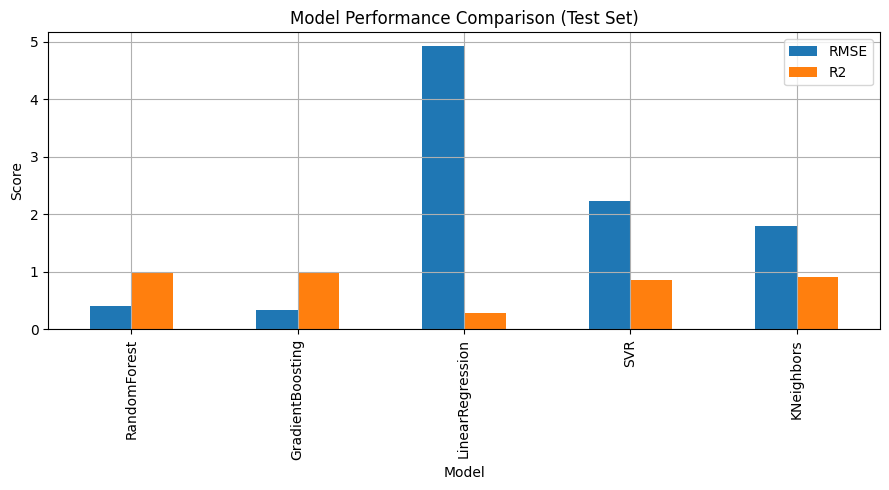

In [16]:
df_results = pd.DataFrame(results, columns=["Model", "RMSE", "R2"])
df_results.set_index("Model")[["RMSE", "R2"]].plot(kind="bar", figsize=(9, 5))
plt.title("Model Performance Comparison (Test Set)")
plt.ylabel("Score")
plt.grid(True)
plt.tight_layout()
plt.show()

Plot actual vs predicted for the best model


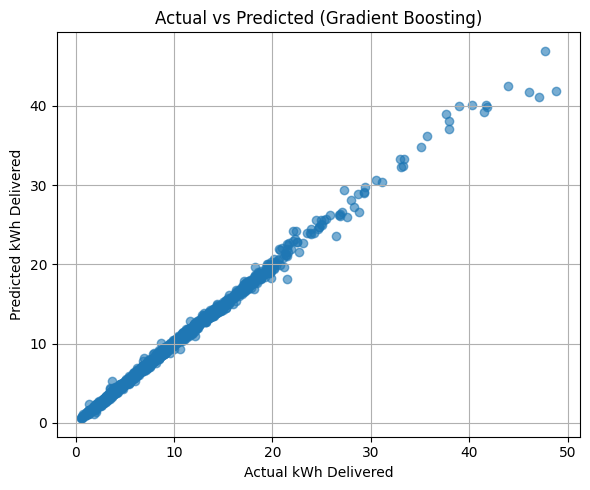

In [17]:
best_model = models["GradientBoosting"]
test_predictions = best_model.predict(X_test)

plt.figure(figsize=(6, 5))
plt.scatter(y_test, test_predictions, alpha=0.6)
plt.xlabel("Actual kWh Delivered")
plt.ylabel("Predicted kWh Delivered")
plt.title("Actual vs Predicted (Gradient Boosting)")
plt.grid(True)
plt.tight_layout()
plt.show()


saving the best model 

In [18]:
joblib.dump(best_model, "gradient_boosting_model.pkl")


['gradient_boosting_model.pkl']